# Support Vector Machines

### Vocabulary
* Bias: the amount of simplification applied to make the real model easier to estimate
* Variance: how much the product is changed by different training data (higher is typically overfitting)
* Margins: the distances between the threshhold (descision boundary) and the nearest sample.
* Soft margins: allow some misclassification by using a rule like the margin is based on the  2nd correctly classified member of a class.
* Support Vector Classifiers: use soft margins to determine the optimal decision boundary. Applies when data can be seperated neatly by 1 line
* Support Vector Machine: adds dimensionality to data (you could do this by for example adding an axis that is a function of the previous) so that data that can't be seperated with a straight line or plane in its usual representation.
  1. Transform data
  2. Apply support vector classifier
* Kernel: find representations of the data in higher dimensions
  * the polynomial kernel increases the number of dimension along with the degree of the polynomial used to represent the data in that dimension
  * radial kernel acts as a weighted k-nearest neighbor classifier
* The kernel trick: transforming data to higher dimension and then applying dot product can be simplified to first doing a dot product then doing further transformation. This is a **trick** because doing the dot product first is computationally inexpensive since the dot product is at its center a reductive operation.
* Decision boundaries
* Support vectors: the samples (vectors) around the decision boundary that contribute to the boundary's location. In the long form of the decision boundary they are the $x_{i}$ with a weights $a_{i} > 0$.
* Lagrange multipliers: a modification of the function ( = $=f(x,y)$)you are differentiating to take into account constraints.
  * The constraints take on the form of a function ( $= g(x,y)$) set equal to a constant c. The constraint function g(x) is itself constrained onto the space that the main function occupies.
  * When the lagrangian acheives a maximum or minimum, the tangent lines of the f and g are parallel and their countour lines are tangent (touching)
* SMO (Sequential Minimal Operations): optimizes Lagrangian multipliers two at a time

### The Lagrangian
* You have a function you want to optimize, $f(x,y)$
* But you have a constraint on this function $g(x,y) = c$
* Looking at a countour graph, the 2 functions must (by definition) intersect at the constrained max value. At this intersection point, though, they also must share the same tangent line to the countour. This implies that their gradient must also share the same line (parallel or antiparallel) because gradient is perpendicular to the countour line tangent. This can be expressed as such:
$$\nabla f(x,y) = \lambda \nabla g(x,y)$$
where $\lambda$ is a constant scalar
* Because the gradient is just many partial derivates in vector form, this can be broken down into many equations that can be solved
* The lagrangian takes this principle and combines it into 1 component
  1. The constraint $g(x,y) = c$ is turned into $g(x,y) - c = 0$
  2. The function $f(x,y)$ is turned into the lagrangian $L(x,y,\lambda) = f(x,y) - \lambda(g(x,y) - c)$
* The lagrangian has the same output as $f(x,y)$ which means that the constraint $g(x,y) - c$ must always be met
* The gradient of the lagrangian matches the relationship between gradient of $f(x,y)$ and $g(x,y)$

### The (Lagrangian) Dual
* The primal is the original maximization problem, and the dual is the minimization form of the same problem
* The dual is the problem we want to solve because it is easier
* $d* \leq p*$ because of the way that the problems are formulate (the dual is in the max min form while the primal is in the min max form)
* We are specifically looking for the case when the dual is equal to the primal because then we can just solve the dual and get the answer we want

### Soft margins
* Hard margin: when you require all points in the training set to follow $y_{i}(w^{T}x_i + b) \geq C$ where c is some constant, typically 1 for ease.
* This sacrifices some generalizability, however, when you have outlier points in the training dataset that end up shaping the final decision boundary heavily -- you may end up with a narrower "street" than you would otherwise. It also means you might end up with a non-seperable case
* Therefore, allow the margins of some points to be ignored: $y_{i}(w^{T}x_i + b) \geq C - \xi_{i}$
* In effect you create the optimization problem where you try to maximize the size of the street while trying to minimize the amount of soft margin ($\sum \xi_{i}$) . The amount that the sum of the soft margin is weighted is denoted by $C$, which is a hyperparameter 
* C turns out to be upper bound of the lagrangian multiplier (otherwise the dual is the same). This is the only practical trace of the soft margin in implementation

### Polyclass Cases
* When the classification is more than binary, you simply apply the algorithm to each combination of classes. For m classes $${m(m-1) \over 2}$$

<center>Resources</center>

Patrick Winston. 6.034 Artificial Intelligence. Fall 2010. Massachusetts Institute of Technology: MIT OpenCourseWare, https://ocw.mit.edu. License: Creative Commons BY-NC-SA.
            
https://www.youtube.com/watch?v=efR1C6CvhmE&vl=en


Alex Botev (https://math.stackexchange.com/users/39340/alex-botev), Max Min of function less than Min max of function, URL (version: 2018-06-27): https://math.stackexchange.com/q/190489

https://stackoverflow.com/a/47964170/13112355

https://stackoverflow.com/a/17025929/13112355

https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/svmtutorial.pdf

http://cs229.stanford.edu/notes/cs229-notes3.pdf

https://www.svm-tutorial.com/2016/09/duality-lagrange-multipliers/

https://shuzhanfan.github.io/2018/05/understanding-mathematics-behind-support-vector-machines/

https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/constrained-optimization/a/lagrange-multipliers-single-constraint

Platt, J. (1998). Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines. Microsoft Research Technical Report.

http://cs229.stanford.edu/materials/smo.pdf

In [1]:
from matplotlib import style
import matplotlib.pyplot as plt
import numpy as np

style.use('ggplot')

In [2]:
# The svm wants to increase the seperation to each class
# Assume that the decision bounary has already been found. How can we use it?

class svm:
    def __init__(self, rng, visualization = True):
        self.visualization = visualization
        self.w = np.random.randn(2)
        self.a = None
        self.b = 0.0
        self.rng = rng
        if self.visualization:
            self.fig, self.ax = plt.subplots()
    
    def calc_w(self, x, y, a = None):
        if a == None:
            a = self.a
        self.w = np.sum(a.reshape(-1,1) * y.reshape(-1,1) * x, axis = 0)
        
    def fit(self, data, K, max_passes, C, tol, recalc_w = True, reuse_a = True):
        """
        Fit the SVM using the methods outlined by Andrew Ng (from CS229 at Stanford) and Platt (from Microsoft)
        
        Parameters:
        ---------
        data: list
            data[0] is np array of shape (n_samples, n_features). data[1] is a np array of shape (n_samples) containing truth values (-1 or 1).
        K: function
            kernel function used
        max_passes: int
            the number of times that no lagrange multipliers are optimized before the function terminates.
        C:
            The maximum value of any lagrange multplier. In the theory behind the algorithm, this is how heavily "soft" examples are meant to be minimized
        tol: float
            the tolerance area where the error is considered to be acceptable
        recalc_w: bool, default = True
            whether to calculate w and assign it to self.w at the end of the fit
        reuse_a: bool, defulat = True
            whether to use a previous run's lagrange multipliers in the current run.
        """
        
        
        # Helper functions to clean up code
        def L_H(a, y, i, j, C):
            # sum(ai*yi) = 0
            # therefore: a1*y1 + a2*y1 = constant, which means that there is a line that contains all combos of a1 and a2 
            # H is the maximum value  of a2 (governed by that line) within the boundbox of c
            # L is the minimum value
            a1 = a[i]
            a2 = a[j]

            if y[i] != y[j]:
                L = max(0, a2-a1)
                H = min(C, C + a2 - a1)
            else:
                L = max(0, a1 + a2 - C)
                H = min(C, a1 + a2)
            
            return (L, H)  

        def calc_fx(i, K, a, y, x, b):
            sum = b
            for k in range(len(x)):
                sum += a[k]*y[k]*K(x[k], x[i])
            return sum
        
        x = data[0]
        y = data[1]
        if self.a != None and reuse_a == True:
            a = self.a
        else:
            a = np.zeros(len(x))
        
        self.K = K
        
        # passes is the number of passes since anything has changed
        passes = 0
        while passes < max_passes:
            num_changed_alphas = 0
            for i, ai in enumerate(a):
                
                # The numerical "error" in the prediction. This is the functional margin - yi
                Ei = calc_fx(i, K, a, y, x, self.b) - y[i]
                
                # KKT conditions are the optimization constraints. For all i
                # ai = 0, yi*f(xi) >= 0 (non supporting vectors) 
                # when 0<ai<C, yi*f(xi) = 1
                # when ai = C, yi*f(xi) <= 1 (ai must be C when this is the case because this means that this an example within the margin ie, part of the soft margin)
                
                if ((y[i]*Ei < -tol and ai < C) or (y[i]*Ei > tol and ai > 0)):
                    
                    j = self.rng.choice(np.arange(len(a))[np.arange(len(a)) != i])
                    Ej = calc_fx(j, K, a, y, x, self.b) - y[j]
                    aj = a[j]
                    
                    # sum(ai*yi) = 0
                    # therefore: a1*y1 + a2*y1 = constant, which means that there is a line that contains all combos of a1 and a2 
                    # H is the maximum value  of a2 (governed by that line) within the boundbox of c
                    # L is the minimum value
                    L, H = L_H(a, y, i, j, C)
                    if L == H:
                        continue
                    
                    
                    eta = 2*np.dot(x[i].T, x[j]) - np.dot(x[i].T, x[i]) - np.dot(x[j].T, x[j]) # Compare the similarity of x1 and x2 and each individually
                    if eta >= 0:
                        continue
                    
                    # "Clipping" the value of a2 to fit within the boundbox using L and H (see above) 
                    aj_new = aj - (y[j]*(Ei - Ej)) / eta
                    if aj_new > H:
                        aj_new = H
                    elif aj_new < L:
                        aj_new = L
                    
                    # If aj_new is small enough of a change, there's no point updating other vars
                    if (abs(aj_new - aj) < 10**(-5)):
                        a[j] = aj_new
                        continue
                    ai_new = ai + y[i]*y[j]*(aj - aj_new)
                    
                    # General ideas: subtract the amount of error so you can eleminate the error and fulfill KKT conditions
                    b1 = self.b - Ei - y[i]*(ai_new - ai)*K(x[i], x[i]) - y[j]*(aj_new - aj)*K(x[i], x[j])
                    b2 = self.b - Ej - y[j]*(ai_new - ai)*K(x[i], x[j]) - y[j]*(aj_new - aj)*K(x[j], x[j])
                    
                    if 0<ai_new<C:
                        self.b = b1
                    elif 0<aj_new<C:
                        self.b = b2
                    else:
                        (b1+b2)/2
                    
                    a[i] = ai_new
                    a[j] = aj_new
                    
                    num_changed_alphas += 1
            if num_changed_alphas == 0:
                passes += 1
            else:
                passes = 0
        
        self.a = a
        if recalc_w:
            self.calc_w(x, y,)
        
    def predict(self, x):
        return np.sign(self.K(x, self.w) + self.b)

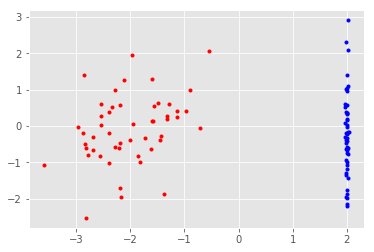

(100, 2)
(100,)


In [3]:
# From https://stackoverflow.com/a/47964170/13112355

from sklearn.datasets import make_classification

separable = False
while not separable:
    samples = make_classification(n_samples=100, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=-1, class_sep = 2)
    red = samples[0][samples[1] == 0]
    blue = samples[0][samples[1] == 1]
    separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() for k in range(2)])
plt.plot(red[:, 0], red[:, 1], 'r.')
plt.plot(blue[:, 0], blue[:, 1], 'b.')
plt.show()

# Our dataset
print(samples[0].shape)
print(samples[1].shape)

samples[1][samples[1] == 0] = -1

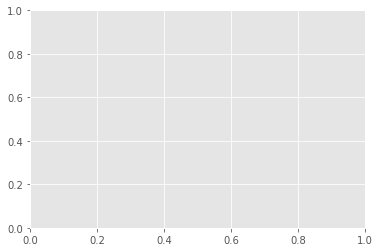

In [19]:
rng = np.random.default_rng()

model = svm(rng,)

def poly_k(x,z):
    return np.dot(x.T,z)

model.fit(samples, poly_k, 100, 1, 10**(-3))

w: [ 0.78847593 -0.01379514] b: -0.5441876926565637
True
5.0


Text(0.5,1,'Decision Boundary from Custom SVC')

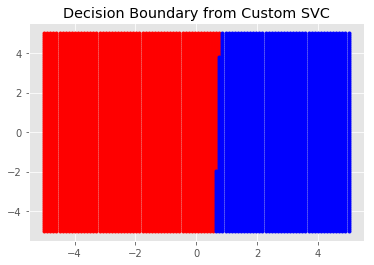

In [20]:
print('w:', model.w, 'b:', model.b)

x = np.linspace(-5,5, num = 100)
y = np.linspace(-5,5, num = 100)

x_plus = np.concatenate(np.split(np.stack([x]*len(y)), len(x), axis = 1))
y_plus = np.concatenate([x]*len(x))

c = np.zeros(x_plus.shape[0])

for i, x_y in enumerate(zip(x_plus, y_plus)):
    pred = model.predict(np.array(x_y))
    if pred == 1:
        c[i] = 1

print(np.any(c == 1))

red_x = x_plus[c == 0]
red_y = y_plus[c == 0]

blue_x = x_plus[c == 1]
blue_y = y_plus[c == 1]

plt.plot(red_x, red_y, 'r.')
plt.plot(blue_x, blue_y, 'b.')

print(max(red_y))
plt.title('Decision Boundary from Custom SVC')

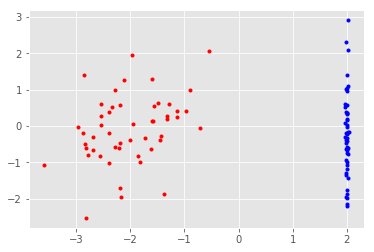

In [6]:
pred_arr = []
for x in samples[0]:
    pred = np.sign(np.dot(x, model.w) + model.b)
    pred_arr.append(pred)
pred_arr = np.array(pred_arr)
    
red = samples[0][pred_arr == -1]
blue = samples[0][pred_arr == 1]

plt.plot(red[:, 0], red[:, 1], 'r.')
plt.plot(blue[:, 0], blue[:, 1], 'b.')
plt.show()

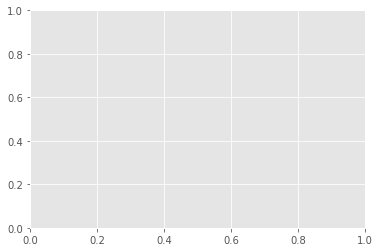

In [7]:
from sklearn.datasets import make_circles

nl_data = make_circles(n_samples = 500, noise = 0.0) 

def poly_k_3d(x,z):
    return np.dot(x.T,z)**2

nl_model = svm(rng)
nl_model.fit(nl_data, poly_k_3d, 100, 1, 10**(-3))

w: [0. 0.] b: 0.0
False


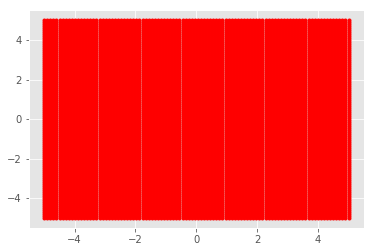

In [14]:
print('w:', nl_model.w, 'b:', nl_model.b)

x = np.linspace(-5,5, num = 100)
y = np.linspace(-5,5, num = 100)

x_plus = np.concatenate(np.split(np.stack([x]*len(y)), len(x), axis = 1))
y_plus = np.concatenate([x]*len(x))

c = np.zeros(x_plus.shape[0])

for i, x_y in enumerate(zip(x_plus, y_plus)):
    pred = nl_model.predict(np.array(x_y))
    if pred == 1:
        c[i] = 1

print(np.any(c == 1))

red_x = x_plus[c == 0]
red_y = y_plus[c == 0]

blue_x = x_plus[c == 1]
blue_y = y_plus[c == 1]

plt.plot(red_x, red_y, 'r.')
plt.plot(blue_x, blue_y, 'b.')

In [43]:
# Adapted from https://stackoverflow.com/a/17025929/13112355

from scipy import optimize
from mpl_toolkits.mplot3d.axes3d import Axes3D

# x is what we would call w
# H is what we would call x

x0 = np.random.randn(2)

b = 0



def loss(x, sign = 1.):
    return sign * (.5*(np.linalg.norm(x))**2)

def jac(x, sign = 1.):
    return (sign * x)

cons = {
    'type':'ineq',
    'fun':lambda x: np.dot(y,(np.dot(H, x + b))) - 1,
    'jac':lambda x: np.dot(y.T, H)
}

opt = {'disp':False}

def solve():
    res_cons = optimize.minimize(loss, x0, jac = jac, constraints = cons, method = 'SLSQP', options = opt)
    
    return res_cons

res_cons = solve()



     fun: 1.3374321699559069e-05
     jac: array([ 0.00517002, -0.00013994])
 message: 'Optimization terminated successfully'
    nfev: 2
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 0.00517002, -0.00013994])


C:\Users\HP\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
C:\Users\HP\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


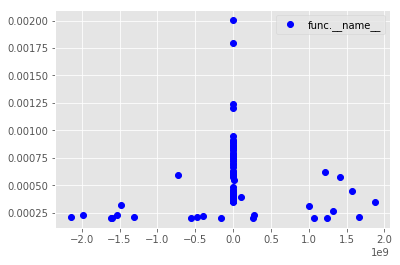

(array([          1,          10,         100,        1000,       10000,
             100000,     1000000,    10000000,   100000000,  1000000000,
         1410065408,  1215752192,  -727379968,  1316134912,   276447232,
        -1530494976,  1874919424,  1569325056, -1486618624, -1981284352,
         1661992960,  -559939584, -1304428544,  -159383552, -1593835520,
         1241513984,  -469762048,  -402653184,   268435456, -1610612736,
         1073741824, -2147483648,           0,           0,           0,
                  0,           0,           0,           0,           0,
                  0,           0,           0,           0,           0,
                  0,           0,           0,           0,           0,
                  0,           0,           0,           0,           0,
                  0,           0,           0,           0,           0,
                  0,           0,           0,           0,           0,
                  0,           0,           0,     

In [55]:
import timeit as tt

def squared_no_k(n):
    x_set = np.linspace(10**100, n, dtype=np.float32)
    
    dots0 = []
    for x in x_set:
        dots0.append(x*x_set)
    dots0 = np.concatenate(dots0).reshape(-1,1)
    
    dots1 = []
    for x in x_set:
        dots1.append(x*x_set)
    dots1 = np.concatenate(dots1).reshape(-1, 1)

    return np.dot(dots0.T, dots1)

def squared_k(n):
    x_set = np.linspace(10*100, n, dtype = np.float32)
    
    return (np.dot(x_set,x_set))**2
    
def o_time_calc(func, Ns , disp_plots = True):
    
    Ns = np.array(Ns)
    
    timings = []
    for N in Ns:
        start = tt.default_timer()
        func(n = N)
        end = tt.default_timer()
        timings.append(end-start)
    
    if disp_plots:
        plt.plot(Ns, timings, 'bo', label = 'func.__name__')
        #plt.plot(Ns, np.log(np.array(Ns)), 'r', label = 'o(log(n))')
        #plt.plot(Ns, Ns**2, 'orange', label = 'o(n^2)')
        #plt.plot(Ns, Ns, 'g', label = 'o(n)')
        plt.legend()
        plt.show()
    return (Ns, timings)

o_time_calc(func = squared_no_k, Ns = 10**np.arange(100),)

[-1] <-- as expected
True
Roughly same as custom SVC:


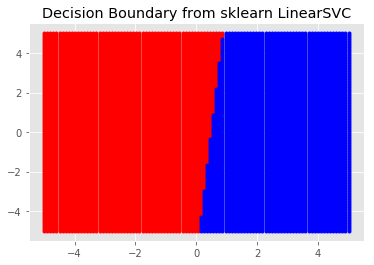

In [17]:
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(samples[0], samples[1])
labels = model.predict(np.array([0,0]).reshape(1,2))
print(labels, '<-- as expected')

x = np.linspace(-5,5, num = 100)
y = np.linspace(-5,5, num = 100)

x_plus = np.concatenate(np.split(np.stack([x]*len(y)), len(x), axis = 1))
y_plus = np.concatenate([x]*len(x))

c = np.zeros(x_plus.shape[0])

for i, x_y in enumerate(zip(x_plus, y_plus)):
    pred = model.predict(np.array(x_y).reshape(1,-1))
    if pred == 1:
        c[i] = 1

print(np.any(c == 1))

red_x = x_plus[c == 0]
red_y = y_plus[c == 0]

blue_x = x_plus[c == 1]
blue_y = y_plus[c == 1]

plt.plot(red_x, red_y, 'r.')
plt.plot(blue_x, blue_y, 'b.')

plt.title('Decision Boundary from sklearn LinearSVC')
print('Roughly same as custom SVC:')

### 1. Type of Data
* Data that can be mapped numerically

### 2. Use Case
* When you are looking to categorize data with great effect
* When you want a clearly interpretable result
* When you are looking for a maximal margin

### 3. Application
* Any categorization area
* Has been surpassed by XGBoost (tree based algorithm)

### 4. Basic Concept
* Seperate data using a line (or another kind of hyperplane) and make the distance between teh data and the seperating line as big as possible
* When you encounter non-linear data, use transformations to a higher dimension to make it linearly seperable

### 5. Assumptions
* Categories exist
* The optimal line on the training data will represent the best line for test data
  * General assumption for all ML algorithms
* Mapping to a higher dimension can be achieved

### 6. Existing solutions
* SKlearn

### 7. Strengths and Weaknesses
#### Strengths
* In linear cases
* Mathematical understandability
* Don't succumb to the diminishing gradient problem
* Can always find global maximum given proper SMO (see Platt) implementation

#### Weaknesses
* Not as effective as XGBoost and other gradient boosted forest classifiers